<a href="https://colab.research.google.com/github/janiosl/python.ds/blob/master/ml/anomaly/ML_Anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CEFET/RJ

**PPCIC - Programa de Pós-Graduação em Ciência da Computação**

**Mestrado em Ciência da Computação**

---

**Detecção de Anomalias**

**Disciplina**: Aprendizado de Máquina

**Professor**: Eduardo Bezerra

**Aluno**: Janio de Souza Lima

#Preparação do ambiente

In [1]:
#Importação de bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.optimize as opt 

In [2]:
from google.colab import drive
#Conecta o Google Colab ao Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Define o path dos códigos e dados como diretório de trabalho atual
import os
dir = '/content/drive/My Drive/Mestrado PPCIC/03. Curso/3. Aprendizado/t2'
os.chdir(dir)

#1 Detecção de Anomalias

Para analisar o comportamento de servidores em um data center, serão analisados dados coletados relativos à vazão em mb/s e latência em ms. Inicialmente, carregamos os dados e geramos uma visualização básica da dispersão das características.

In [4]:
#Carga do arquivo
import scipy.io as spio
arquivo = 'data/ex8data1.mat'
data = spio.loadmat(arquivo)

In [5]:
#Conferência dos dados
#Saída muito extensa - Comentada para uso apenas para na conferência
#print(data)

#Carga dos subconjuntos de treino, teste e validação
X = np.array(data['X'])

X_val = np.array(data['Xval'])
y_val = np.array(data['yval'])

In [6]:
#Conferência da dimensão do conjunto de dados
print(X.shape, X_val.shape, y_val.shape)

(307, 2) (307, 2) (307, 1)


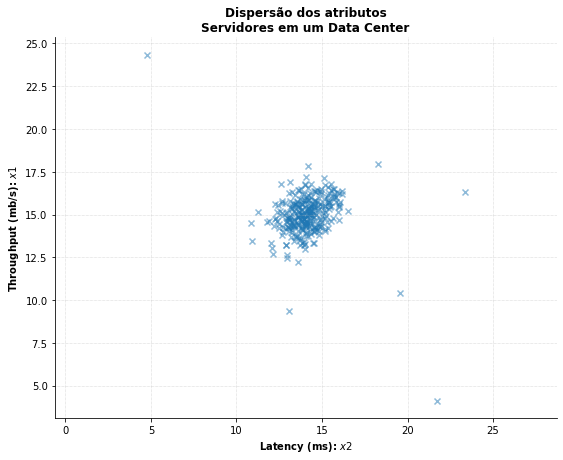

In [90]:
plt.figure(figsize=(9,7))
plt.grid(color='0.7', linestyle=':', linewidth=0.5)

#Dispersão dos dados
plt.scatter(X[:,0], X[:,1], marker='x', alpha=0.5)


#Configurações visuais adicionais
plt.title('Dispersão dos atributos\nServidores em um Data Center',
          fontweight='bold')
plt.ylabel('Throughput (mb/s): $x1$', fontweight='bold')
plt.xlabel('Latency (ms): $x2$', fontweight='bold')
plt.axis('equal')
sns.despine()

plt.savefig('target/plot4.png')

#1.1 Distribuição Gaussiana

Nesta seção vamos analisar os dados em mais detalhes e na sequência, para identificar anomalias, vamos estimar parâmetros para a distribuição *gaussiana*.

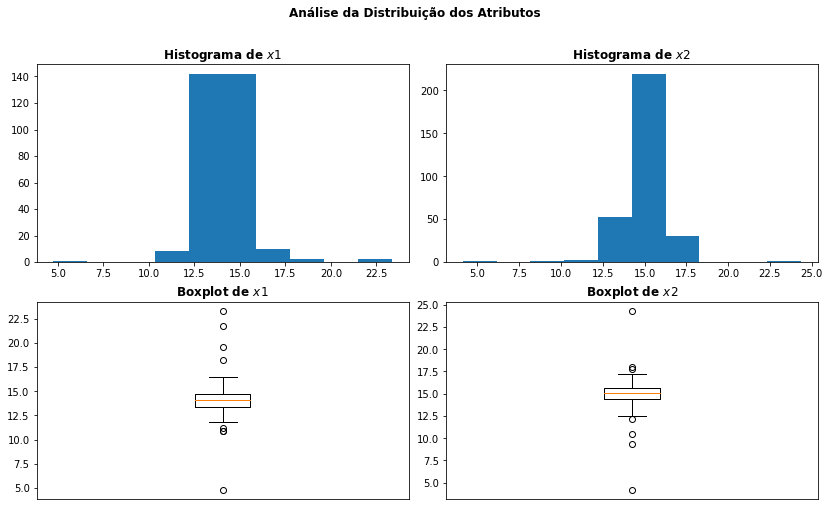

In [19]:
fig = plt.figure(figsize=(14,8))
fig.suptitle('Análise da Distribuição dos Atributos', fontweight='bold')

#Criação dos subplots
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)


#Histogramas
ax1.hist(X[:,0])
ax1.set_title('Histograma de $x1$', fontweight='bold')

ax2.hist(X[:,1])
ax2.set_title('Histograma de $x2$', fontweight='bold')


#Boxplots
ax3.boxplot(X[:,0])
ax3.set_title('Boxplot de $x1$', fontweight='bold')

ax4.boxplot(X[:,1])
ax4.set_title('Boxplot de $x2$', fontweight='bold')


#Configurações visuais adicionais
ax3.set_xticks([])
ax4.set_xticks([])
plt.subplots_adjust(wspace=0.1)

plt.savefig('target/plot4.1.1.png')

As visualizações acima já permitem uma primeira intuição da existência de *outliers* no conjunto de dados, como pode ser vistos nos pontos acima dos limites inferiores e superiores de outliers, bem como pelas observações existentes em faixas de valores afastadas dos pontos médios de cada histograma.

#1.2 Estimativa de parâmetros para uma gaussiana

Para prosseguir a análise será implementada uma função do zero para estimativa dos parâmetros da distribuição *gaussiana*.

In [102]:
def estimate_gaussian_params(X):
  """
  Essa funcao deve computar e retornar mu e sigma2,
  vetores que contem a media e a variancia de cada
  caracteristica (feature) de X.
  """
  ########################
	# SEU CODIGO AQUI :
	########################
  mu = np.mean(X, axis=0)
  sigma2 = np.var(X, axis=0)

  return (mu, sigma2)

In [103]:
mu, sigma2 = estimate_gaussian_params(X)
print(f'mu:     {mu}\nsigma2: {sigma2}')

mu:     [14.11222578 14.99771051]
sigma2: [1.83263141 1.70974533]


Com a implmentação chegamos aos vetore com os valores de $\mu$ e $\sigma^2$ apresentados na listagem anterior.

---

Agora plotaremos os a visualização dos contornos da distribuição *gaussiana* ajustada.

In [104]:
#Função implementada do repositório da disciplina sem alterações
# Source: https://github.com/Grzego/handwriting-generation/issues/16 
def bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0,
                     mux=0.0, muy=0.0, sigmaxy=0.0):
    """
    Bivariate Gaussian distribution for equal shape *X*, *Y*.
    See `bivariate normal
    <http://mathworld.wolfram.com/BivariateNormalDistribution.html>`_
    at mathworld.
    """
    Xmu = X-mux
    Ymu = Y-muy

    rho = sigmaxy/(sigmax*sigmay)
    z = Xmu**2/sigmax**2 + Ymu**2/sigmay**2 - 2*rho*Xmu*Ymu/(sigmax*sigmay)
    denom = 2*np.pi*sigmax*sigmay*np.sqrt(1-rho**2)
    return np.exp(-z/(2*(1-rho**2))) / denom

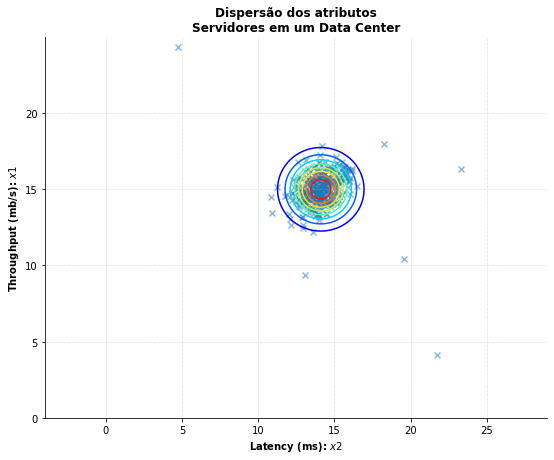

In [105]:
#Dados adicionais para construção dos contornos
x = np.arange(0, 25, .025)
y = np.arange(0, 25, .025)
first_axis, second_axis = np.meshgrid(x, y)

Z = bivariate_normal(first_axis, second_axis,
                     np.sqrt(sigma2[0]), np.sqrt(sigma2[1]),
                     mu[0], mu[1])

plt.figure(figsize=(9,7))
plt.grid(color='0.7', linestyle=':', linewidth=0.5)

#Dispersão dos dados
plt.scatter(X[:,0], X[:,1], marker='x', alpha=0.5)

#Contornos da Gaussiana
plt.contour(first_axis, second_axis, Z, 10, cmap=plt.cm.jet)

#Configurações visuais adicionais
plt.title('Dispersão dos atributos\nServidores em um Data Center',
          fontweight='bold')
plt.ylabel('Throughput (mb/s): $x1$', fontweight='bold')
plt.xlabel('Latency (ms): $x2$', fontweight='bold')
plt.axis('equal')
sns.despine()

plt.savefig('target/plot4.2.png')

Nesta visualização os círculos plotados pelo contorno representam a distribuição gaussiana estimada para o conjunto de dados. Pode-se perceber que a maioria das observações estão dentro dos limites de maior probabilidade. Os valores fora destes limites tem menor probabilidade de ocorrência na distribuição *gaussiana* e por isso representam anomalias.

#1.3 Selecionando $\epsilon$

#Referências e Links

**Referências**

Géron, Aurélien (2019). **Mãos à Obra Aprendizagem de Máquina com Scikit-Learn & TensorFlow:** Conceitos, ferramentas e técnicas para a construção de sistemas inteligentes. Traduzido por Rafael Contatori. Alta Books.

Grus, Joel (2016). **Data Science do Zero:** Primeiras regras com Python. Traduzido por Welington Nascimento. Alta Books.

McKinney, Wes (2018). **Python para Análise de Dados**: tratamento de dados com pandas, numpy e iPython. Traduzido por Lúcia A. Kinoshita. Novatec.

---

https://github.com/MLRG-CEFET-RJ/ml-class/tree/master/ml-t2/detanom